## 1. Prepare the environment

Optional: download all the python libraries if you not already present in the environment

In [1]:
! python.exe -m pip install --upgrade pip
! pip install --upgrade moku
! pip install zeroconf
%pip install --q moku[neuralnetwork]


Note: you may need to restart the kernel to use updated packages.


Import the Python libraries

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import moku
import numpy as np
import os
from pathlib import Path
from datetime import datetime
import time


In [3]:
from moku.instruments import MultiInstrument
from moku.instruments import Oscilloscope

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed.")
    print("If you're running in a Notebook like Google Colab, uncomment the first line in this cell and run it again")
    print("Otherwise install the moku library with neural network extensions using `pip install moku[neuralnetwork]`")
    raise

Define the relevant functions

In [4]:
def format_sampling_rate(rate):
    if rate >= 1e6:
        return f"{rate/1e6:.2f} MHz"
    elif rate >= 1e3:
        return f"{rate/1e3:.2f} kHz"
    else:
        return f"{rate:.2f} Hz"

In [5]:
def save_data_to_csv(data_points, window_size, filename):
    # Ensure all values are floats
    data_points = [float(x) for x in data_points]

    # Compute total number of windows
    windows = []
    num_points = len(data_points)
    i = 0

    while i + window_size <= num_points:
        windows.append(data_points[i:i + window_size])
        i += window_size

    # Handle the last partial window
    if i < num_points:
        # Start the last window earlier to make it full size
        start = max(0, num_points - window_size)
        windows.append(data_points[start:num_points])

    # Check if file exists and read current ID count
    file_exists = os.path.exists(filename)
    next_id = 0
    if file_exists:
        with open(filename, mode='r', newline='') as file:
            reader = csv.reader(file)
            next(reader, None)  # Skip header
            next_id = sum(1 for _ in reader)

    # Open file in append mode (create if doesn't exist)
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write header if file is new
        if not file_exists:
            writer.writerow(['id', 'data'])

        # Write each window
        for w in windows:
            writer.writerow([next_id, ';'.join(f'{x:.6f}' for x in w)])
            next_id += 1

    print(f"Total n. of frames in the output file: {next_id}")


In [6]:
def load_data_from_csv(filename):
    data_windows = []

    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # Skip header if it exists

        for row in reader:
            if len(row) < 2:
                continue  # Skip malformed rows
            # Split the 'data' field and convert back to floats
            float_values = [float(x) for x in row[1].split(';')]
            data_windows.append(float_values)

    return data_windows


List the available moku devices

In [7]:
! mokucli list

Name                 Serial  HW     FW     IP                  
---------------------------------------------------------------
MokuGo-000051        51      Go     608    fe80::7269:79ff:feb9:cc%16
MokuGo-004186        4186    Go     606    fe80::7269:79ff:feb9:4168%16
MokuLab-002094       2094    Lab    608    fe80::72b3:d5ff:fe87:b82e%16
MokuPro-000323       323     Pro    606    fe80::7269:79ff:feb0:570%16


## 2. Set up the Oscilloscope for data collection

Set up folder structure for the output data and define filenames

In [8]:
# Output filenames
output_folder = "AD_dataset/"
output_filename_anomaly = "data_training_ad_20"

timestamp = str(time.time()).split(".")[-1]

output_filename_anomaly = f"{output_folder}{output_filename_anomaly}_{timestamp}.csv"
print(f"Data will be saved in the file: {output_filename_anomaly}" )


# If the folder doesn't exist it, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder created: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")


Data will be saved in the file: AD_dataset/data_training_ad_20_5503702.csv
Folder already exists: AD_dataset/


Deploy the Oscilloscope

In [9]:
# Replace in the code below the first input variable with your Moku IP adrress and platform id based on your Moku
# Initialize the MultiInstrument with Moku:Go IP address and configuration
mim = MultiInstrument('10.1.119.245', force_connect=True, platform_id=4)
osc = mim.set_instrument(4, Oscilloscope)

In [10]:
connections = [dict(source="Input1", destination="Slot4InA")]
mim.set_connections(connections=connections)

[{'destination': 'Slot4InA', 'source': 'Input1'}]

In [11]:
mim.set_frontend(channel=1, impedance="50Ohm", coupling="DC", attenuation="-20dB")

{'attenuation': '-20dB', 'coupling': 'DC', 'impedance': '50Ohm'}

The following is specific to the training dataset:
- window_size define how many datapoints our signal "sample" consist of
- n_frames is the number of frames we want to collect from the oscilloscope for the training dataset

In [12]:
window_size = 100
n_frames = 100
t1 = 0    # Start time in seconds
t2 = 1
duration = t2 - t1
osc.set_timebase(t1, t2)


{'t1': 0.0, 't2': 1.0}

Collect the data.
For testing - uncomment the code block below to print out the "frames" from the oscilloscope.

In [13]:
for i in range(n_frames):
    data = osc.get_data()  # Get the data from the oscilloscope

    '''plt.ion()
    fig, ax = plt.subplots(figsize=(12, 4))  # Wider aspect ratio

    ax.grid(visible=True)
    ax.set_ylim([-0.5, 0.5])
    ax.set_xlim([data['time'][0], data['time'][-1]])

    line1, = ax.plot([], label='Channel 1')
    line1.set_ydata(data['ch1'])
    line1.set_xdata(data['time'])

    # Show legend if useful
    ax.legend()

    # Draw the updated plot
    fig.canvas.draw()
    fig.canvas.flush_events()

    '''

    print(f'{i} - Saved {len(data["ch1"])} points from the oscilloscope')
    save_data_to_csv(data["ch1"], window_size, filename=output_filename_anomaly)


0 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 11
1 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 22
2 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 33
3 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 44
4 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 55
5 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 66
6 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 77
7 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 88
8 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 99
9 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 110
10 - Saved 1024 points from the oscilloscope
Total n. of frames in the output file: 121
11 - Saved 1024 points from the oscilloscope
Total 

Print a full frame

1024


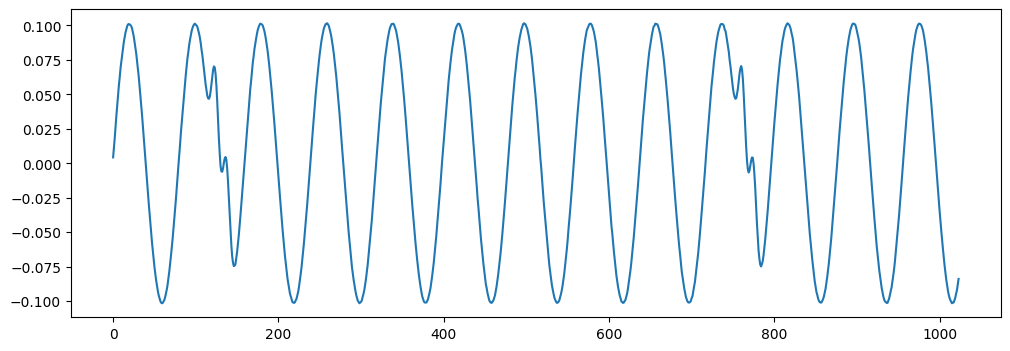

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))  
plt.plot(data['ch1'])
print(len(data['ch1']))

Print the first 100 datapoints of the frame

sampling rate: 1.02 kHz


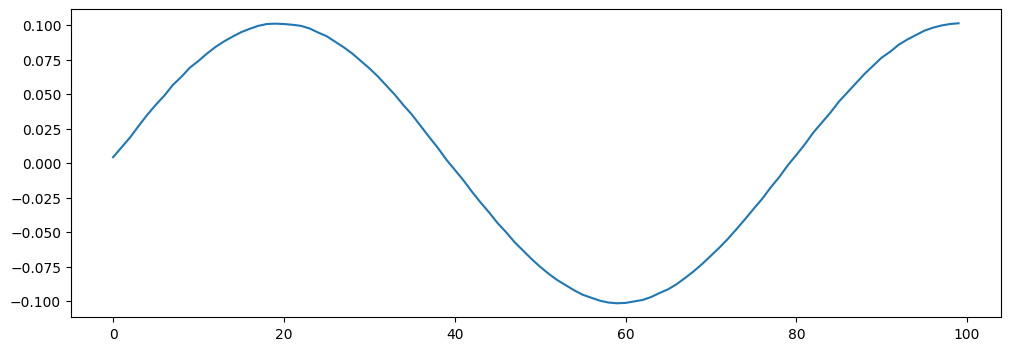

In [15]:
fig, ax = plt.subplots(figsize=(12, 4)) 
plt.plot(data['ch1'][:100])
sampling_rate = len(data['ch1'] )/(duration)
print('sampling rate:', format_sampling_rate(sampling_rate))

## 3. Compose the training dataset

In [8]:
# Read from the saved files
output_filename = 'AD_dataset/data_training_ad_20_5503702.csv' 
data = load_data_from_csv(output_filename)

# Split into training and testing set
data_anomaly_frames = int(len(data)*0.8)
full_training_dataset = data[:data_anomaly_frames]
full_testing_dataset = data[data_anomaly_frames:]


print(f"N. of frames  in the training dataset: {len(full_training_dataset)}")
print(f"N. of  frames in the testing dataset: {len(full_testing_dataset)}")


N. of frames  in the training dataset: 880
N. of  frames in the testing dataset: 220


## 4. Define the model and train

In [9]:
quant_mod = LinnModel()

In [10]:
# Set up the early stopping - the below checks every 10 epochs 

early_stopping_config = {
    'patience': 10,   # Allow 10 epochs without improvement
    'restore_best_weights': True
}

In [11]:
frame_length = len(full_training_dataset[0])
print(f"frame length/input dimension: {frame_length}")

# Define the model
quant_mod.set_training_data(training_inputs=full_training_dataset, training_outputs=full_training_dataset)
model_definition = [(64, 'tanh'), (32, 'tanh'), (16, 'tanh'), (frame_length, 'linear')]

# build the model
quant_mod.construct_model(model_definition)

frame length/input dimension: 100



In [12]:
# Train the model
history = quant_mod.fit_model(epochs=100, es_config=early_stopping_config, validation_split=0.1)

Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5272 - val_loss: 0.3595
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3150 - val_loss: 0.2060
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1780 - val_loss: 0.1039
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0932 - val_loss: 0.0492
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0512 - val_loss: 0.0252
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - val_loss: 0.0158
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.0124
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.0108
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0098
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - val_loss: 0.0091
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0085
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

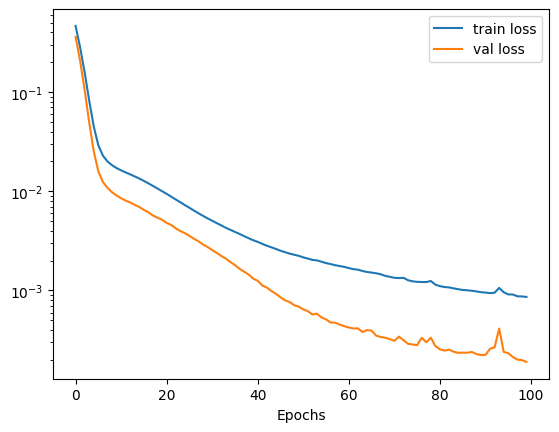

In [13]:
# plot the training and validation losses
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.show()

Save the model

In [22]:
model_filename = 'AD_model_final_20.linn'
T = np.linspace(-1, 1, frame_length)

save_linn(quant_mod, input_channels=1, output_channels=1, file_name=model_filename, output_mapping=[T.size-1])


Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 224 cycles


# 5. Testing the model - reconstruct the training dataset
This is used to see how well the model has learnt to reconstruct the data from the training dataset

In [14]:
quant_mod.eval()

AttributeError: 'LinnModel' object has no attribute 'eval'

In [23]:
reconstructions = []
reconstructions = quant_mod.predict(full_training_dataset)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Test on an frame with a glitch

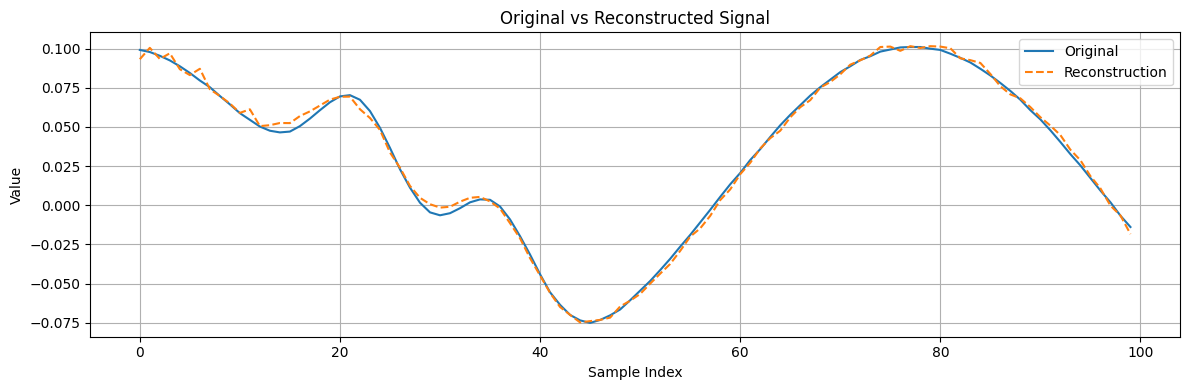

In [25]:
frame_id_normal = 225

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_normal], label='Original')
plt.plot(reconstructions[frame_id_normal], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


Test of a normal frame

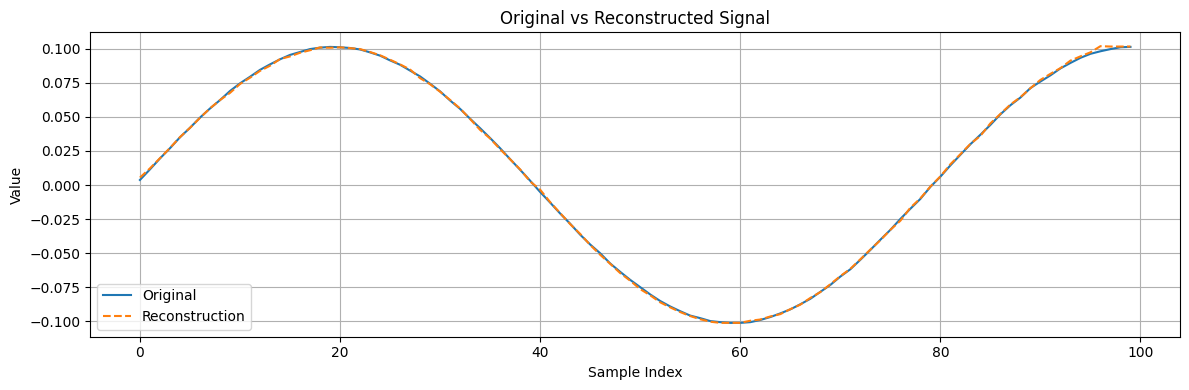

In [26]:
frame_id_nomral = 220

plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id_nomral], label='Original')
plt.plot(reconstructions[frame_id_nomral], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Testing the model on the testing dataset (unseen data)
This is used to see how well the model generalize the signal reconstruction on never seens before waveforms.

In [27]:
reconstructions_test = []
reconstructions_test = quant_mod.predict(full_testing_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Test on an frame with a glitch

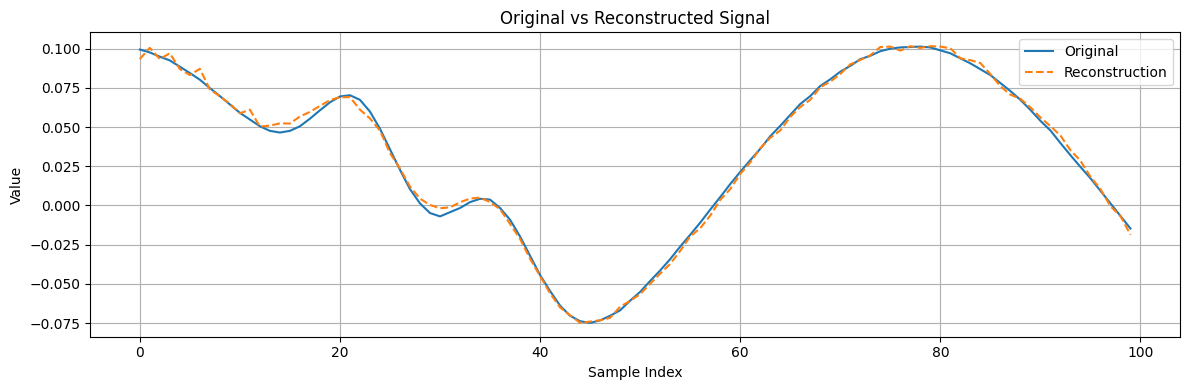

In [50]:
frame_id_anomaly_test = 27

plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset[frame_id_anomaly_test], label='Original')
plt.plot(reconstructions_test[frame_id_anomaly_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


Test on a normal frame

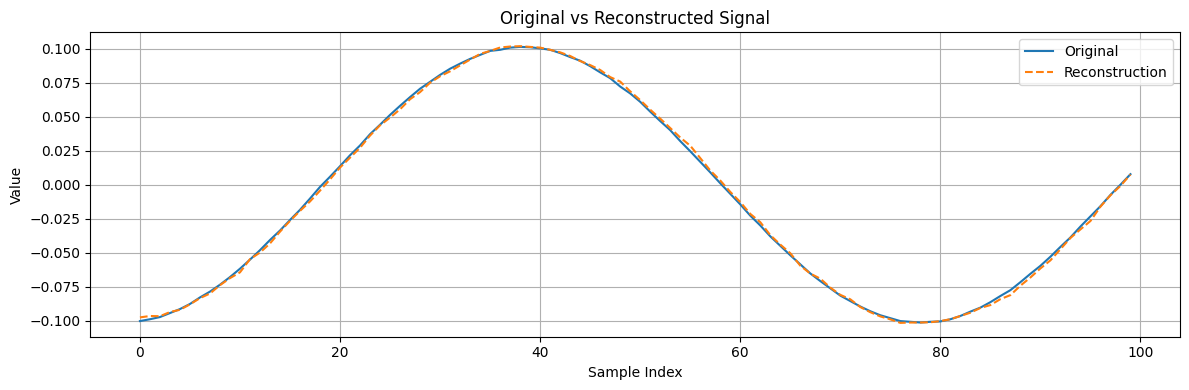

In [51]:
frame_id_normal_test = 146

plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset[frame_id_normal_test], label='Original')
plt.plot(reconstructions_test[frame_id_normal_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Extract the reconstruction error

In [52]:
original = np.array(full_testing_dataset)
reconstructed = np.array(reconstructions_test)

# --- Error Calculations ---
# Element-wise absolute error
absolute_error = np.abs(original - reconstructed)

# Element-wise squared error
squared_error = (original - reconstructed) ** 2

# Total error per sample (row-wise)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)


#### Absolute error

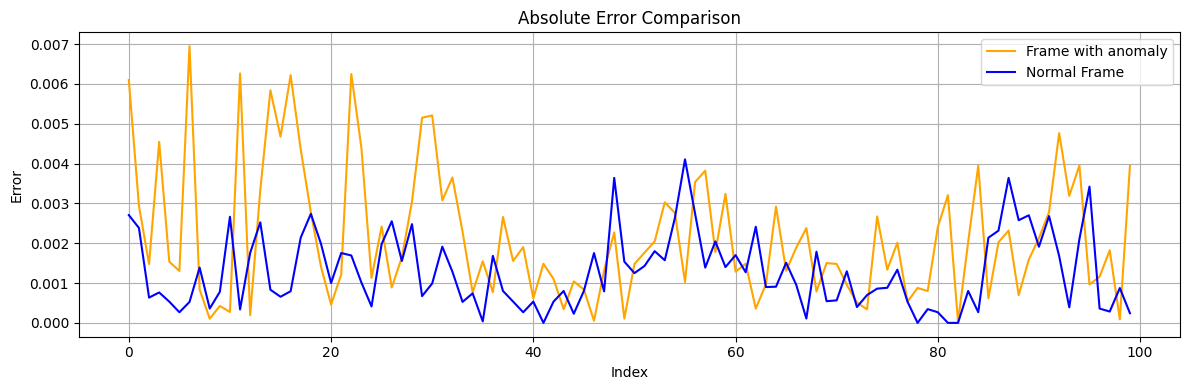

In [53]:
# --- Plotting both frame_ids together ---
plt.figure(figsize=(12, 4))

plt.plot(absolute_error[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(absolute_error[frame_id_normal_test], label='Normal Frame', color='blue')

plt.title('Absolute Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
threshold = 0.125

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(absolute_error[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [absolute_error[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: []
Corresponding values: []
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


#### Squared error

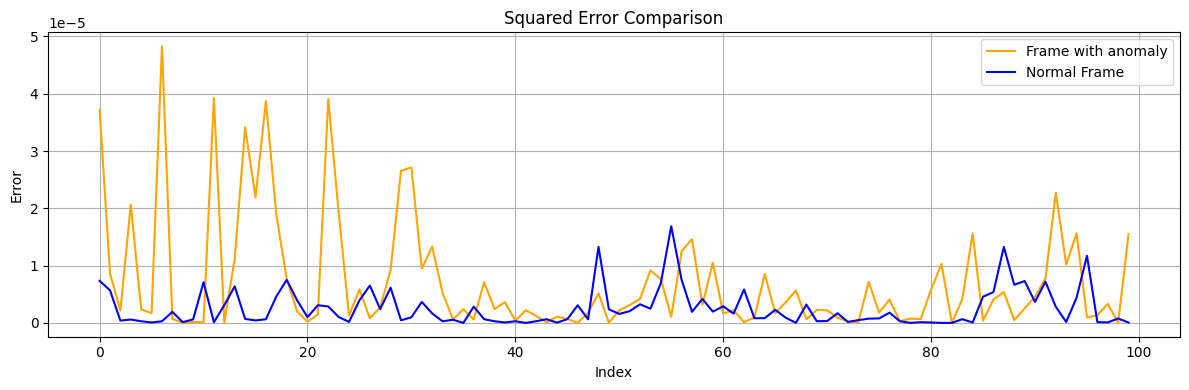

In [55]:
plt.figure(figsize=(12, 4))

plt.plot(squared_error[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(squared_error[frame_id_normal_test], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
threshold = 0.02

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(squared_error[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [squared_error[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: []
Corresponding values: []
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


### Focal loss

In [57]:
def focal_mse_loss(prediction, target, gamma=2.5):
    error = prediction - target
    squared_error = error ** 2
    loss = squared_error ** gamma
    return loss

In [58]:

focal_loss = focal_mse_loss(reconstructed, original)  # element-wise focal loss
focal_loss_per_frame = focal_loss.sum(axis=1)

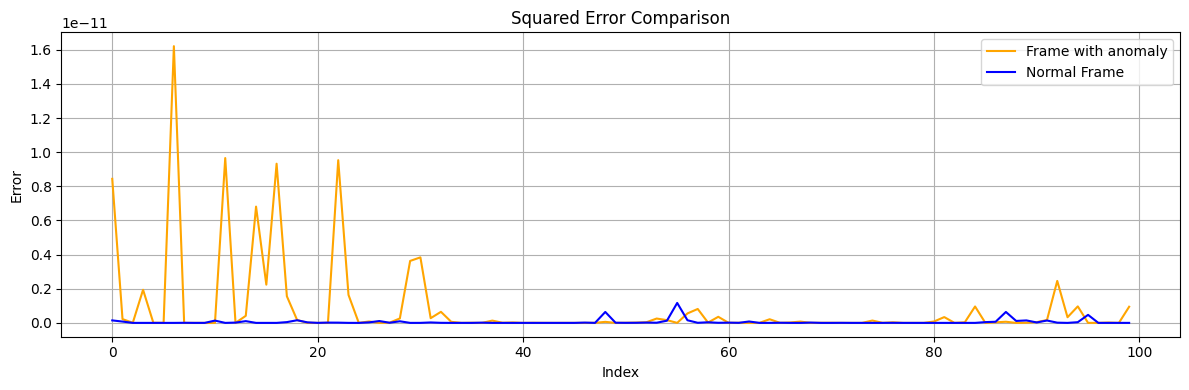

In [59]:

plt.figure(figsize=(12, 4))

plt.plot(focal_loss[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(focal_loss[frame_id_normal_test], label='Normal Frame', color='blue')

plt.title('Squared Error Comparison')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
threshold = 0.00005

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: []
Corresponding values: []
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []
